In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import gurobipy as gp
from gurobipy import GRB
import scipy
import tqdm

In [9]:
def gillespie(params, n, tmax=100, ts=10, plot=False, initial_state=(0, 0)):
    '''
    Simulate a sample path of the birth death regulation model
    Sample n values at intervals of ts after a burn-in time of tmax

    params: dict of reaction rate constants
    n: number of samples
    tmax: burn in time
    ts: time between samples
    '''

    # initialize random generator
    rng = np.random.default_rng()

    # initialise time and state
    t = 0
    path = [initial_state]
    jump_times = [0]

    # simulate for burn-in time and time between n samples
    while t < tmax + (n - 1) * ts:

        # current state
        x1, x2 = path[-1][0], path[-1][1]

        # transition rates
        q_tx_1 = params['k_tx_1']
        q_tx_2 = params['k_tx_2']
        q_deg_1 = x1 * params['k_deg_1']
        q_deg_2 = x2 * params['k_deg_2']
        q_reg = x1 * x2 * params['k_reg']
        q_hold = q_tx_1 + q_tx_2 + q_deg_1 + q_deg_2 + q_reg

        # holding time in current state
        t_hold = -np.log(rng.uniform()) / q_hold
        t += t_hold
        jump_times.append(t)

        # jump probability
        outcome = [1, 2, 3, 4, 5]
        prob = [
            q_tx_1 / q_hold,
            q_tx_2 / q_hold,
            q_deg_1 / q_hold,
            q_deg_2 / q_hold,
            q_reg / q_hold
        ]
        jump = rng.choice(outcome, p=prob)
        match jump:
            case 1:
                path.append((x1 + 1, x2))
            case 2:
                path.append((x1, x2 + 1))
            case 3:
                path.append((x1 - 1, x2))
            case 4:
                path.append((x1, x2 - 1))
            case 5:
                path.append((x1 - 1, x2 - 1))

    # take the transcript states
    x1_path = [state[0] for state in path]
    x2_path = [state[1] for state in path]

    # create step function of sample path from jump times and jump values
    x1_path_function = scipy.interpolate.interp1d(jump_times, x1_path, kind='previous')
    x2_path_function = scipy.interpolate.interp1d(jump_times, x2_path, kind='previous')

    # take values at sampling times as samples from stationary dist
    sample_times = [tmax + i * ts for i in range(n)]
    x1_samples = x1_path_function(sample_times)
    x2_samples = x2_path_function(sample_times)

    # convert to integers
    x1_samples = [int(x1) for x1 in x1_samples]
    x2_samples = [int(x2) for x2 in x2_samples]

    # re-combine to pairs of samples
    samples = list(zip(x1_samples, x2_samples))

    # plot sample paths
    if plot:
        x = np.linspace(0, tmax + (n - 1) * ts, 10000)
        plt.plot(x, x1_path_function(x), label="X1 sample path", color="blue")
        plt.plot(x, x2_path_function(x), label="X2 sample path", color="purple")
        #plt.axvline(tmax, label="Burn-in time", color="orange")
        plt.xlabel("Time")
        plt.ylabel("Counts")
        plt.legend()
        plt.show()

    return samples

# Downsampling Simulation

Sample a dataset of model parameters and simulate a count dataset, then sample a vector of per cell capture efficiency and apply a downsampling procedure to produce a new dataset.

Capture efficiency is sampled from a distribution informed from data e.g. Beta(1, 20), but needs to be truncated to avoid too small values (unrealistic and cause issues)

## Dataset Simulation

In [86]:
def simulate_dataset(gene_pairs, cells, interaction_chance=0.5, conditional=True, sig=0.5, plot=True, min_int=-1, max_int=1):
    '''
    Produce dataset of gene pairs' simulated parameters and samples.

    Produce a dataset of pairs of genes where for each pair parameters of a
    birth-death regulation model are simulated, and then a sample of size
    'cells' is simulated from the model. Parameters are sampled from log-uniform 
    distributions informed by single cell RNA sequencing experiments to produce
    realistic data. The paramters and samples are returned in a dictionary of 2
    pandas dataframes.

    Args:
        gene_pairs: number of gene pairs to simulate
        cells: number of samples to simulate per gene pair
        interaction_chance: float in [0, 1], chance the interation parameter
                            'k_reg' is sampled vs being set to 0 (no interaction)
        conditional: toggle if model parameters for each gene in the pair are
                    sampled independently (False) or conditionally (True)
        sig: standard deviation about common value for parameters of each gene
            during conditional sampling 
        plot

    Returns:
        dictionary of parameter and count dataframes
    '''

    # initialize random generator
    rng = np.random.default_rng()

    # dataframes
    params_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=['k_tx_1', 'k_tx_2', 'k_deg_1', 'k_deg_2', 'k_reg'])
    counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    # for each gene
    for i in tqdm.tqdm(range(gene_pairs)):

        # Select if interation or not
        u = rng.uniform()
        if u < interaction_chance:
            interaction = True
        else:
            interaction = False

        # Simulate reaction rate parameters 

        # conditional sampling
        if conditional:

            # sample log-mean capture efficiency
            log_mean = rng.uniform(-0.5, 1.5)

            # sample from normal distribution about the log-mean
            log_mean_1 = rng.normal(log_mean, sig)
            log_mean_2 = rng.normal(log_mean, sig)

            # sample degradation rates for each gene
            log_k_deg_1 = rng.uniform(-1, 0)
            log_k_deg_2 = rng.uniform(-1, 0)

            # compute transcription rates using log-mean and deg rate
            log_k_tx_beta_1 = log_mean_1 + log_k_deg_1
            log_k_tx_beta_2 = log_mean_2 + log_k_deg_2

            # sample interaction strength
            if interaction: log_k_reg = rng.uniform(min_int, max_int)

        # independent sampling
        else:

            # sample rates from log-uniform distribution for both genes
            log_k_tx_beta_1 = rng.uniform(-1, 1.5)
            log_k_tx_beta_2 = rng.uniform(-1, 1.5)
            log_k_deg_1 = rng.uniform(-1, 0)
            log_k_deg_2 = rng.uniform(-1, 0)
            if interaction: log_k_reg = rng.uniform(-2, 2)

        # exponentiate and scale
        k_tx_1  = 10 ** log_k_tx_beta_1
        k_tx_2  = 10 ** log_k_tx_beta_2
        k_deg_1 = 10 ** log_k_deg_1
        k_deg_2 = 10 ** log_k_deg_2
        if interaction:
            k_reg = 10 ** log_k_reg
        else:
            k_reg = 0

        # store parameters
        params_df.iloc[i] = [k_tx_1, k_tx_2, k_deg_1, k_deg_2, k_reg]

        params = {
            'k_tx_1': k_tx_1,
            'k_tx_2': k_tx_2,
            'k_deg_1': k_deg_1,
            'k_deg_2': k_deg_2,
            'k_reg': k_reg
        }

        # simulate sample from model
        sample = gillespie(params, cells)

        # store counts
        counts_df.iloc[i] = sample

    # plot
    if plot:
        plt.scatter(np.log10(params_df['k_tx_1'].astype(np.float64)) - np.log10(params_df['k_deg_1'].astype(np.float64)), np.log10(params_df['k_tx_2'].astype(np.float64)) - np.log10(params_df['k_deg_2'].astype(np.float64)))
        plt.xlabel("log(k_tx_1 / k_deg_1)")
        plt.ylabel("log(k_tx_2 / k_deg_2)")
        plt.title("Scatter plot of gene-pair parameters")
        plt.show()

    return {'params_df': params_df, 'counts_df': counts_df}

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


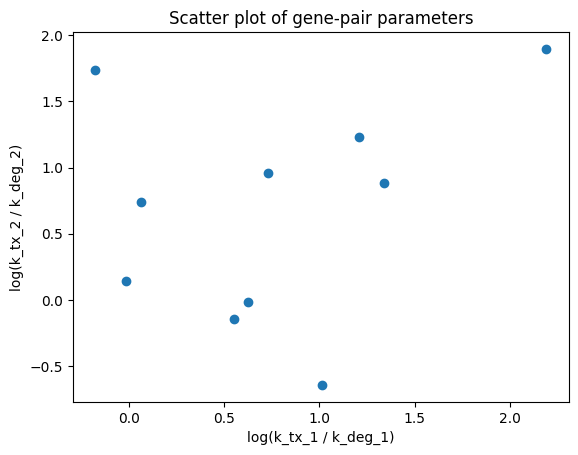

In [53]:
datasets_test = simulate_dataset(gene_pairs=10, cells=100, interaction_chance=0.5, conditional=False, sig=0.5, plot=True)

## Capture efficiency simulation

In [23]:
def simulate_capture(cells, threshold=0.01, plot=False):
    '''
    Simulate a vector of length 'cells' from the distribution Beta(1, 20) 
    thresholding small values and store in a 
    '''
    # initialize random generator
    rng = np.random.default_rng()

    # sample vector
    beta_sampled = rng.beta(1, 20, size=cells)

    # threshold
    beta_sampled[beta_sampled < threshold] = threshold

    # display
    if plot:
        plt.hist(beta_sampled, label=f"Mean = {beta_sampled.mean()}", bins=cells // 10);
        plt.legend()

    return beta_sampled

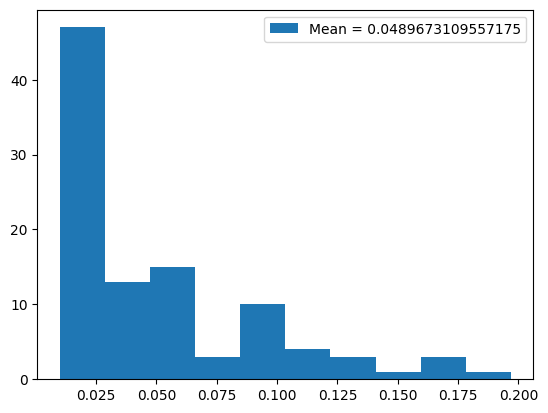

In [54]:
beta = simulate_capture(100, plot=True)

## Downsampling simulation

In [30]:
def simulate_downsampled_dataset(counts_df, beta):
    '''
    Apply capture efficiency vector 'beta' to produce downsampled dataset using
    the given 'count_df'
    '''

    # get dataset size
    gene_pairs, cells = counts_df.shape

    # error if incomptible cell numbers
    if not (cells == beta.shape[0]):
        print("Incompatible cell numbers")
        return None
    
    # initialize random generator
    rng = np.random.default_rng()

    # setup downsampled dataset
    downsampled_counts_df = pd.DataFrame(index=[f"Gene-pair-{i}" for i in range(gene_pairs)], columns=[f"Cell-{j}" for j in range(cells)])

    for i in range(gene_pairs):

        # extract counts
        sample = counts_df.iloc[i]
        x1_sample = [x[0] for x in sample]
        x2_sample = [x[1] for x in sample]

        # downsample
        x1_sample_downsampled = rng.binomial(x1_sample, beta).tolist()
        x2_sample_downsampled = rng.binomial(x2_sample, beta).tolist()
        sample_downsampled = list(zip(x1_sample_downsampled, x2_sample_downsampled))
        
        # store counts
        downsampled_counts_df.iloc[i] = sample_downsampled

    return downsampled_counts_df

In [55]:
datasets_downsampled_test = simulate_downsampled_dataset(datasets_test['counts_df'], beta)

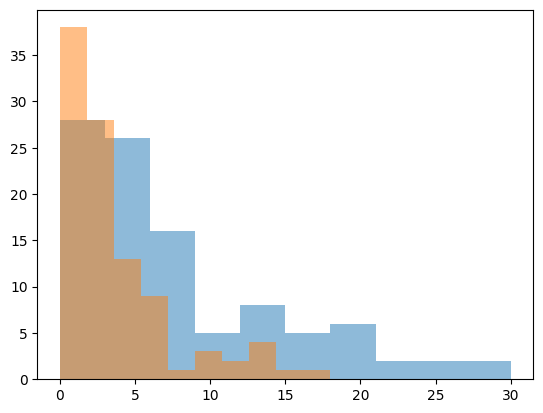

In [72]:
i = 0
plt.hist([x[0] for x in datasets_downsampled_test.iloc[i]], alpha=0.5)
plt.hist([x[1] for x in datasets_downsampled_test.iloc[i]], alpha=0.5)
plt.show()

# Simulation

100%|██████████| 200/200 [15:42<00:00,  4.71s/it]


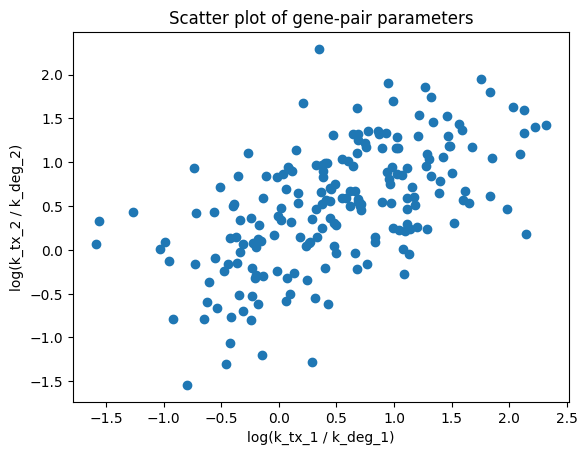

In [81]:
# simulate 'easy' datasets (no downsampling)
datasets_easy = simulate_dataset(gene_pairs=200, cells=1000, interaction_chance=0.5, conditional=True, sig=0.5, plot=True)

# store
datasets_easy['params_df'].to_csv("../Sampled-Capture-Data/Datasets/params_easy.csv")
datasets_easy['counts_df'].to_csv("../Sampled-Capture-Data/Datasets/counts_easy.csv")

100%|██████████| 200/200 [18:20<00:00,  5.50s/it]


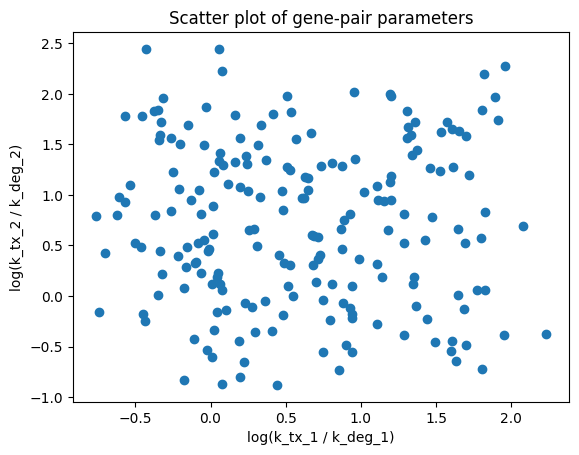

In [82]:
# simulate 'hard' datasets (no downsampling)
datasets_hard = simulate_dataset(gene_pairs=200, cells=1000, interaction_chance=0.5, conditional=False, sig=0.5, plot=True)

# store
datasets_hard['params_df'].to_csv("../Sampled-Capture-Data/Datasets/params_hard.csv")
datasets_hard['counts_df'].to_csv("../Sampled-Capture-Data/Datasets/counts_hard.csv")

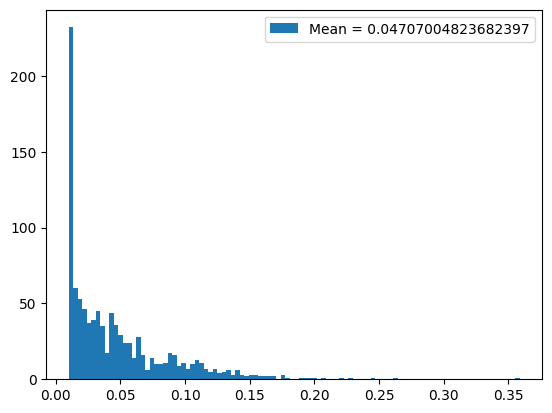

In [83]:
# simulate capture efficiency vector
beta = simulate_capture(cells=1000, plot=True)

# store
np.savetxt("../Sampled-Capture-Data/Datasets/beta.csv", beta, delimiter=",")

In [84]:
# downsample 'easy' dataset
counts_easy_downsampled = simulate_downsampled_dataset(datasets_easy['counts_df'], beta)

# store
counts_easy_downsampled.to_csv("../Sampled-Capture-Data/Datasets/counts_easy_downsampled.csv")

In [85]:
# downsample 'hard' dataset
counts_hard_downsampled = simulate_downsampled_dataset(datasets_hard['counts_df'], beta)

# store
counts_hard_downsampled.to_csv("../Sampled-Capture-Data/Datasets/counts_hard_downsampled.csv")

# Simulation: higher interaction

100%|██████████| 100/100 [12:36<00:00,  7.56s/it]


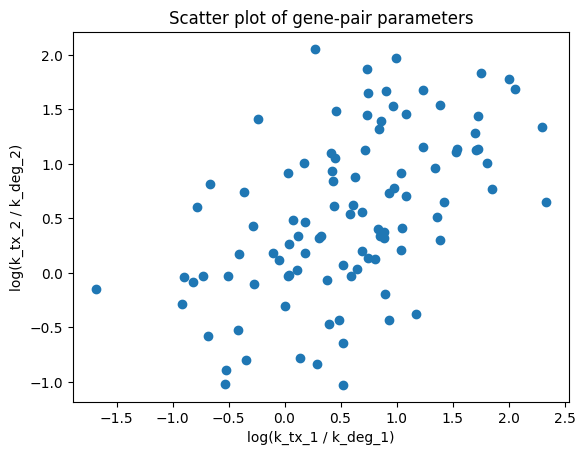

In [89]:
# simulate 'easy' datasets (no downsampling)
datasets_easy_HINT = simulate_dataset(gene_pairs=100, cells=1000, interaction_chance=0.5, conditional=True, sig=0.5, plot=True,
                                 min_int=0, max_int=2)

# store
datasets_easy_HINT['params_df'].to_csv("../Sampled-Capture-Data/Datasets/params_easy_HINT.csv")
datasets_easy_HINT['counts_df'].to_csv("../Sampled-Capture-Data/Datasets/counts_easy_HINT.csv")

100%|██████████| 100/100 [11:36<00:00,  6.96s/it]


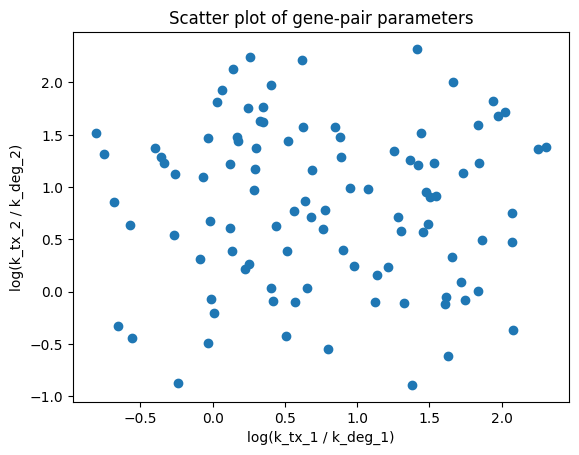

In [90]:
# simulate 'hard' datasets (no downsampling)
datasets_hard_HINT = simulate_dataset(gene_pairs=100, cells=1000, interaction_chance=0.5, conditional=False, sig=0.5, plot=True,
                                 min_int=0, max_int=2)

# store
datasets_hard_HINT['params_df'].to_csv("../Sampled-Capture-Data/Datasets/params_hard_HINT.csv")
datasets_hard_HINT['counts_df'].to_csv("../Sampled-Capture-Data/Datasets/counts_hard_HINT.csv")

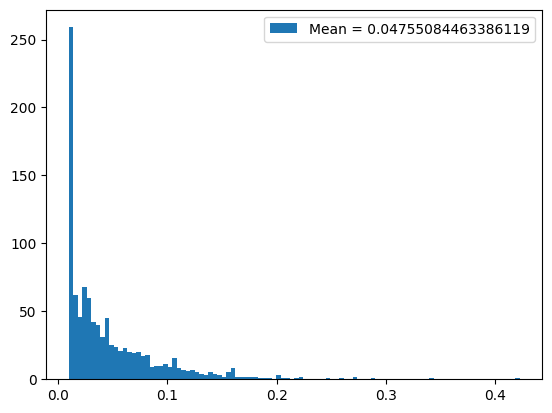

In [91]:
# simulate capture efficiency vector
beta_HINT = simulate_capture(cells=1000, plot=True)

# store
np.savetxt("../Sampled-Capture-Data/Datasets/beta_HINT.csv", beta_HINT, delimiter=",")

In [92]:
# downsample 'easy' dataset
counts_easy_downsampled_HINT = simulate_downsampled_dataset(datasets_easy_HINT['counts_df'], beta_HINT)

# store
counts_easy_downsampled_HINT.to_csv("../Sampled-Capture-Data/Datasets/counts_easy_downsampled_HINT.csv")

In [93]:
# downsample 'hard' dataset
counts_hard_downsampled_HINT = simulate_downsampled_dataset(datasets_hard_HINT['counts_df'], beta_HINT)

# store
counts_hard_downsampled_HINT.to_csv("../Sampled-Capture-Data/Datasets/counts_hard_downsampled_HINT.csv")